In [1]:
import numpy as np
import pandas as pd
import kmapper as km
import kneed
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from networkx.readwrite import json_graph
import json
import collections
from dataclasses import dataclass
import ast
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
NUM_EPOCHS = 176
NUM_POINTS = 457
# NUM_POINTS = 4282
DATA = 'test'

In [15]:
@dataclass
class Config:
    metric: str = 'euclidean'
    filter_func: str = 'l2'
    intervals: int = 50
    overlap: float = 0.5


def read_labels(path):
    label_data = []
    with open(path, 'r') as f:
        for line in f:
            word_info, word_label = line.strip().split('\t')
            sent_info, word = word_info.split(':')
            sent_info = ast.literal_eval(sent_info)
            label_data.append([sent_info[0], sent_info[1], word, word_label])

    return pd.DataFrame(label_data, columns=['sent_id', 'word_id', 'word', 'label'])


def add_node_metadata(graph, metadata_source, activations):
    # create PCA model first
    nodewise_activations = np.vstack([np.mean(activations.iloc[graph['nodes'][node_name]], axis=0) for node_name in graph['nodes']])

    for i, node_name in enumerate(graph['nodes']):
        member_list = graph['nodes'][node_name]

        metadata = [metadata_source.loc[member_index].tolist() for member_index in member_list]
        graph['nodes'][node_name] = {'membership_ids': member_list, 'metadata': metadata,
                                     'l2avg': np.average(metadata_source.loc[member_list]['l2norm']),
                                     'type': 'train'}

    return graph


def elbow_eps(data):
    nbrs = NearestNeighbors(n_neighbors=2).fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)[::-1]
    kneedle = kneed.KneeLocator(distances[:, 1], np.linspace(0, 1, num=len(distances)), curve='convex', direction='decreasing')
    eps = kneedle.knee * 0.75 if kneedle.knee else 5
    return eps


def serialize_graph(graph):
    nx_graph = km.adapter.to_networkx(graph)
    js_graph = json_graph.node_link_data(nx_graph)

    for i, node in enumerate(js_graph['nodes']):
        js_graph['nodes'][i]['name'] = js_graph['nodes'][i]['id']
        js_graph['nodes'][i]['l2avg'] = js_graph['nodes'][i]['membership']['l2avg']

    for i, link in enumerate(js_graph['links']):
        id_s = link['source']
        id_t = link['target']
        mem1 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_s][0]
        mem2 = [x['membership']['membership_ids'] for x in js_graph['nodes'] if x['id'] == id_t][0]
        mem1, mem2 = set(mem1), set(mem2)
        jaccard = len(mem1.intersection(mem2)) / len(mem1.union(mem2))
        js_graph['links'][i]['intersection'] = jaccard

    return js_graph


def get_mapper(activations, labels, conf):

    labels['l2norm'] = np.expand_dims(np.linalg.norm(activations.to_numpy(), axis=1), 1)
    mapper = km.KeplerMapper()

    if conf.filter_func == 'l1':
        projected_data = np.linalg.norm(activations, ord=1, axis=1).reshape((activations.shape[0], 1))
    elif conf.filter_func == 'l2':
        projected_data = mapper.fit_transform(activations, projection='l2norm')
    elif conf.filter_func == 'knn5':
        projected_data = mapper.fit_transform(activations, projection='knn_distance_5') / 5
    else:
        raise KeyError('Unexpected filter function')

    eps = elbow_eps(activations)
    graph = mapper.map(projected_data, activations, clusterer=DBSCAN(eps=eps, metric=conf.metric, min_samples=3),
                       cover=km.Cover(n_cubes=conf.intervals, perc_overlap=conf.overlap))

    add_node_metadata(graph, labels, activations)

    return serialize_graph(graph)


def node_purity(node, label):
    metadata = node['membership']['metadata']
    label_counts = collections.Counter([x[3] for x in metadata])
    return (label_counts[label], len(metadata))


def compute_purities(graph):
    point_node_purities = collections.defaultdict(list)

    for node in graph['nodes']:
        metadata = node['membership']['metadata']

        for i, point_id in enumerate(node['membership']['membership_ids']):
            point_node_purities[point_id].append((i, node_purity(node, metadata[i][3])))

    return point_node_purities


def get_activations_labels(activation_file, label_file):
    activations = pd.read_csv(activation_file, delim_whitespace=True, header=None)
    labels = read_labels(label_file)
    return activations, labels


def wrapper(iteration):
    layer = 12

    ACTIVATION_FILE = f'../backend/data/ss-role/fine-tuned-bert-base-uncased/{DATA}/{iteration}/{layer}.txt'
    label_file = f'../backend/data/ss-role/entities/{DATA}.txt'

    activations, labels = get_activations_labels(ACTIVATION_FILE, label_file)
    config = Config(metric='euclidean', filter_func='l2', intervals=50, overlap=0.5)

    graph = get_mapper(activations, labels, config)

    return compute_purities(graph)


In [16]:
# %%time
# purities = [compute_purities(fileindex) for fileindex in tqdm(range(NUM_EPOCHS))]
# purities = Parallel(n_jobs=5)(delayed(wrapper)(fileindex) for fileindex in tqdm(range(0, NUM_EPOCHS, 5)))

purities = []
for fileindex in tqdm(range(0, NUM_EPOCHS, 5)):
    purities.append(wrapper(fileindex))

  0%|          | 0/36 [00:00<?, ?it/s]

C:\Users\archi\anaconda3\envs\probing\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
C:\Users\archi\anaconda3\envs\probing\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")
C:\Users\archi\anaconda3\envs\probing\lib\site-packages\kneed\knee_locator.py:304: UserWarning: No knee/elbow found
  warnings.warn("No knee/elbow found")


In [30]:
def purity_df(purities):

    def purity_summary(purities):
        if purities is None:
            return -1
        else:
            plist = [x[1] for x in purities]

            numerator = sum([x[0] for x in plist])
            denominator = sum([x[1] for x in plist])
            if denominator != 0:
                return numerator / denominator
            else:
                return -1

    point_purity_tracker = collections.defaultdict(list)

    for point_number in range(NUM_POINTS):
        for iteration in range(len(range(0, NUM_EPOCHS, 5))):

            iteration_purity_dict = purities[iteration]

            point_purity_tracker[point_number].append((iteration, purity_summary(iteration_purity_dict[point_number])))

    node_purities_df = pd.DataFrame(columns=['pointNum'] + [f'epoch_{x}_purity' for x in range(0, NUM_EPOCHS, 5)])

    for pointNum in range(NUM_POINTS):
        row = [pointNum] + [x[1] for x in point_purity_tracker[pointNum]]
        node_purities_df.loc[pointNum] = row

    return node_purities_df


purity_df = purity_df(purities)


In [31]:
# draw ridge plot for each epoch_purity
df = purity_df.melt(id_vars='pointNum', value_vars=[f'epoch_{x}_purity' for x in range(0, NUM_EPOCHS, 5)])
df.rename(columns={'variable': 'g', 'value': 'x'}, inplace=True)

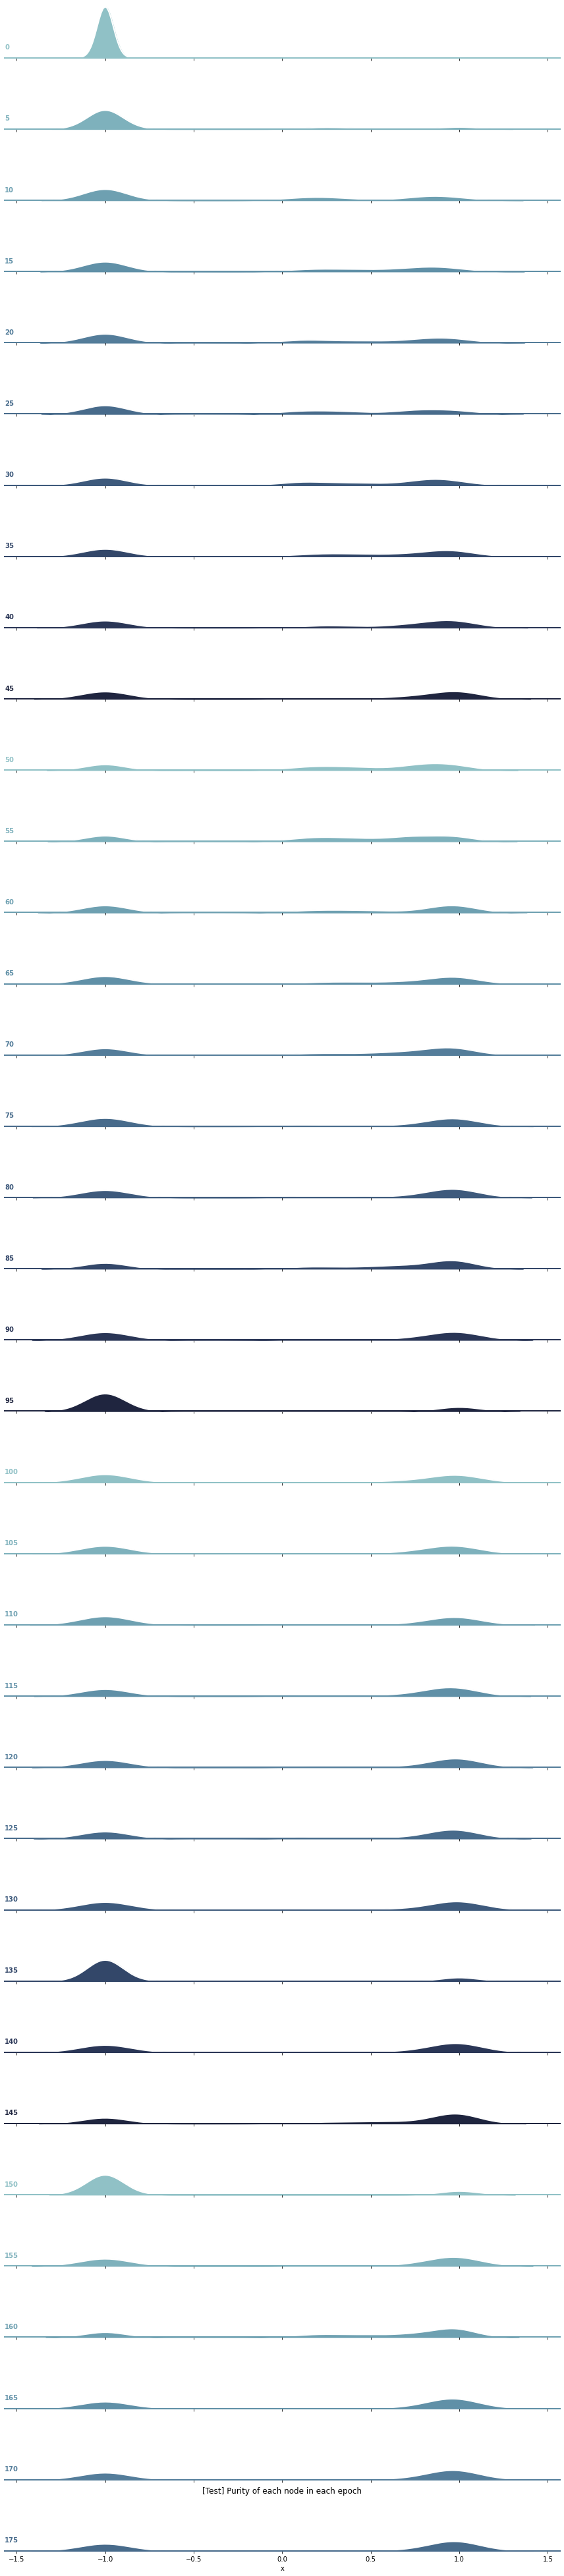

In [32]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=8, height=1.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", bw_adjust=.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    label = label.split("_")[1]
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-1.5)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.title(f'[Test] Purity of each node in each epoch')

plt.tight_layout()